In [1]:
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms
resnet18 = models.resnet18(pretrained=True).to('cuda')

C:\Users\LuanAdemi\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LuanAdemi\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


234 Rottweiler 0.3676997423171997
163 bloodhound 0.18327856063842773
235 German shepherd 0.09958745539188385
244 Tibetan mastiff 0.06533291190862656
185 Norfolk terrier 0.05202478915452957


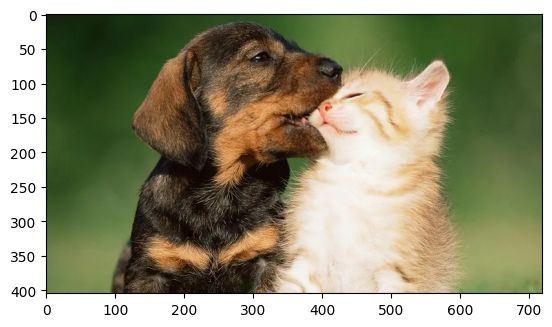

In [2]:
# test the pretrained model using a sample image

input_image = Image.open("data/puppykitty.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to('cuda') # create a mini-batch as expected by the model


resnet18.eval()
with torch.no_grad():
    output = resnet18(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Read the categories
with open("imgnet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

# Show the image
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.asarray(input_image))
plt.show()

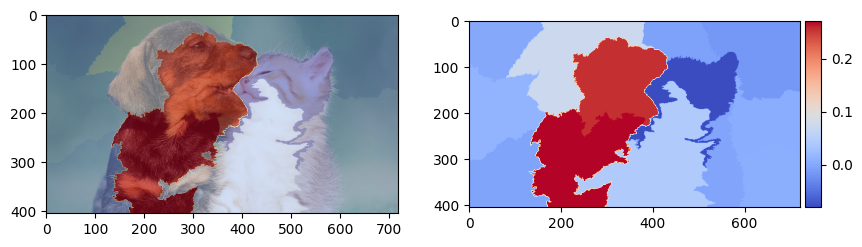

In [6]:
from lime import BinarySampler, LIMEExplainer, ExponentialKernel
from skimage.segmentation import slic

instance = np.asarray(input_image)

segments = slic(instance, n_segments=20, compactness=10)
kernel = ExponentialKernel(1e5)
sampler = BinarySampler(segments, n_jobs=8, alpha=0.3)
explainer = LIMEExplainer(similarity_kernel=kernel, sampler=sampler, cls=234, model=resnet18, preprocess=preprocess)

importances = explainer.explain(instance)